c:\Users\sylee\.conda\envs\py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 기존 FAISS 인덱스 파일이 존재합니다: faiss_index.faiss
❌ 기존 FAISS 인덱스를 로드하는 중 오류 발생: Error in __int64 __cdecl faiss::DirectMap::get(__int64) const at D:\bld\faiss-split_1734618091746\work\faiss\invlists\DirectMap.cpp:82: direct map not initialized
⚙️ 새로운 FAISS 인덱스를 생성합니다.


c:\Users\sylee\.conda\envs\py38\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


📊 클러스터 개수 (노이즈 제외): 242


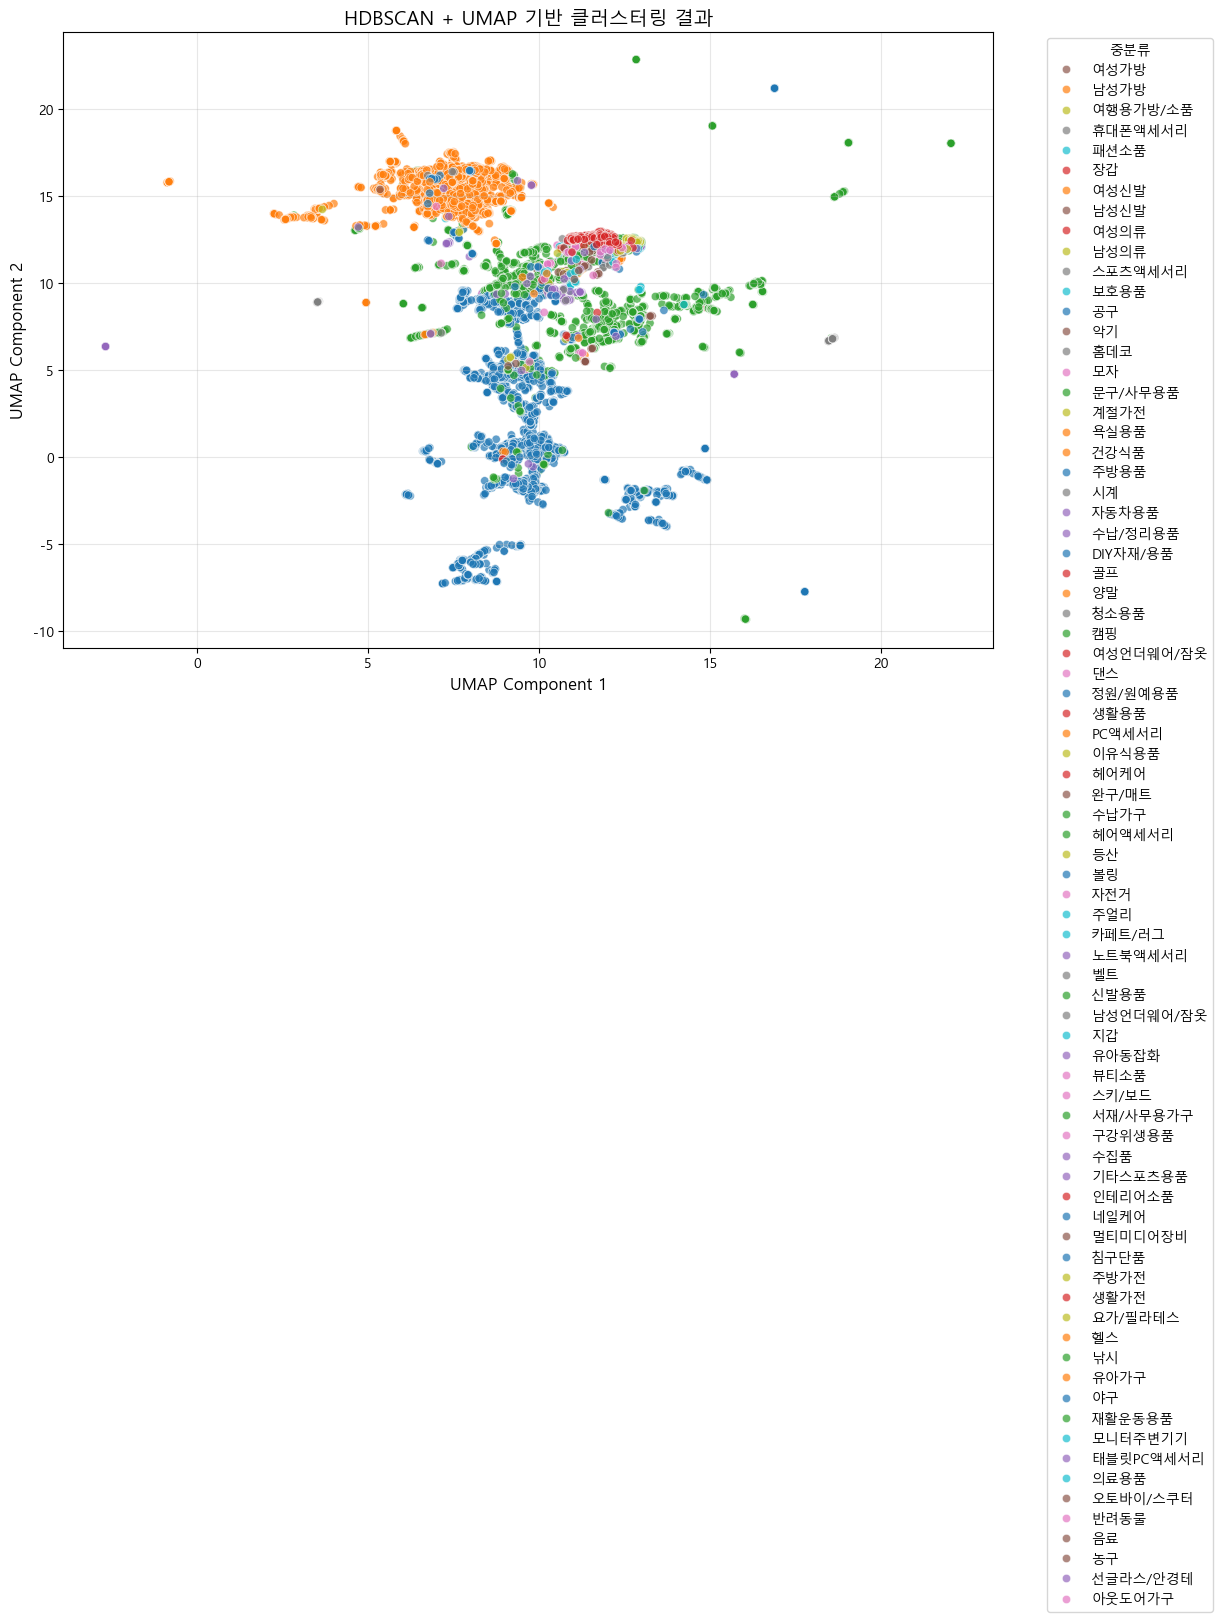

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import faiss
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
import umap
import hdbscan

# ✅ 엑셀 파일 경로 및 FAISS 파일 경로 설정
file_path = "db/오너클랜_클러스터링_0203.xlsx"
faiss_file_path = "faiss_index.faiss"

# ✅ 환경 변수 로드
load_dotenv()
API_KEY = os.getenv('OPENAI_API_KEY')

# ✅ FAISS 인덱스 저장/로드 함수
def save_faiss_index(index, file_path):
    faiss.write_index(index, file_path)

def load_faiss_index(file_path):
    return faiss.read_index(file_path)

# ✅ 엑셀 파일 로드 및 텍스트 변환
def load_excel_to_texts(file_path):
    data = pd.read_excel(file_path)
    texts = data['원본상품명'].dropna().tolist()
    return texts, data

# ✅ FAISS 인덱스 생성 및 저장
def create_and_save_faiss_index(file_path, faiss_file_path):
    try:
        texts, data = load_excel_to_texts(file_path)
        임베딩 = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=API_KEY)
        embeddings = 임베딩.embed_documents(texts)
        embeddings = np.array(embeddings, dtype=np.float32)
        faiss.normalize_L2(embeddings)

        # ✅ IndexIVFFlat 생성 및 DirectMap 활성화
        d = embeddings.shape[1]
        nlist = 200  # 클러스터 개수
        quantizer = faiss.IndexFlatL2(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
        index.maintain_direct_map = True  # DirectMap 활성화
        index.train(embeddings)
        index.add(embeddings)

        # ✅ FAISS 인덱스 저장
        save_faiss_index(index, faiss_file_path)
        return index, embeddings, data
    except Exception as e:
        print(f"❌ FAISS 인덱스 생성 및 저장 오류: {e}")
        return None, None, None



# ✅ FAISS 인덱스 생성 또는 로드
if not os.path.exists(faiss_file_path):
    print(f"⚙️ 새로운 FAISS 인덱스를 생성합니다: {faiss_file_path}")
    faiss_index, embeddings_matrix, df = create_and_save_faiss_index(file_path, faiss_file_path)
else:
    try:
        print(f"✅ 기존 FAISS 인덱스 파일이 존재합니다: {faiss_file_path}")
        faiss_index = load_faiss_index(faiss_file_path)
        faiss_index.maintain_direct_map = True  # DirectMap 활성화
        embeddings_matrix = np.array([faiss_index.reconstruct(i) for i in range(faiss_index.ntotal)])
        _, df = load_excel_to_texts(file_path)
    except RuntimeError as e:
        print(f"❌ 기존 FAISS 인덱스를 로드하는 중 오류 발생: {e}")
        print("⚙️ 새로운 FAISS 인덱스를 생성합니다.")
        faiss_index, embeddings_matrix, df = create_and_save_faiss_index(file_path, faiss_file_path)

# ✅ '카테고리명'에서 중분류 추출
df['중분류'] = df['카테고리명'].str.split('>').str[1]

# ✅ 카테고리별 색상 매핑
category_counts = df['중분류'].value_counts()
unique_categories = category_counts.index
palette = sns.color_palette("tab10", len(unique_categories))
category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}
df['색상'] = df['중분류'].map(category_colors)

# ✅ 한글 폰트 설정 (Windows: Malgun Gothic, macOS: AppleGothic)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지





# ✅ UMAP을 사용한 차원 축소
umap_model = umap.UMAP(n_components=2, random_state=42, metric='cosine')
reduced_embeddings = umap_model.fit_transform(embeddings_matrix)
df[['UMAP1', 'UMAP2']] = reduced_embeddings

# ✅ HDBSCAN 클러스터링 적용
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
cluster_labels = hdbscan_clusterer.fit_predict(reduced_embeddings)
df['Cluster'] = cluster_labels

# ✅ 클러스터링 결과 확인
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)  # -1은 노이즈
print(f"📊 클러스터 개수 (노이즈 제외): {num_clusters}")

# ✅ 클러스터링 결과 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='중분류',
    palette=category_colors,  # 노이즈 포함
    data=df,
    alpha=0.7
)

# ✅ 그래프 설정
plt.title("HDBSCAN + UMAP 기반 클러스터링 결과", fontsize=14)
plt.xlabel("UMAP Component 1", fontsize=12)
plt.ylabel("UMAP Component 2", fontsize=12)
plt.legend(title="중분류", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# ✅ 코사인 유사도 계산 함수
def calculate_cosine_similarity(embeddings_matrix):
    """
    벡터 간 코사인 유사도를 계산합니다.
    """
    cosine_sim_matrix = cosine_similarity(embeddings_matrix)
    return cosine_sim_matrix

# ✅ 코사인 유사도 계산
cosine_sim_matrix = calculate_cosine_similarity(embeddings_matrix)

# ✅ 특정 데이터의 코사인 유사도 및 벡터 값 조회
index = 0  # 첫 번째 데이터
vector_value = embeddings_matrix[index]
cosine_similarities = cosine_sim_matrix[index]

# ✅ 결과 출력
print(f"데이터 인덱스 {index}의 벡터 값:")
print(vector_value)

print(f"\n데이터 인덱스 {index}의 다른 데이터와의 코사인 유사도:")
print(cosine_similarities)

# ✅ 상위 유사 데이터 출력 (상품명 포함)
top_similar_indices = np.argsort(cosine_similarities)[::-1][1:6]  # 자기 자신 제외 상위 5개
print(f"\n데이터 인덱스 {index}와 가장 유사한 데이터 인덱스들:")

# 현재 데이터의 상품명
current_item_name = df.iloc[index]['원본상품명']
print(f"현재 데이터 상품명: {current_item_name}")
print(f"============================================================")

# 상위 유사 데이터 출력
for i in top_similar_indices:
    similar_item_name = df.iloc[i]['원본상품명']  # 유사한 데이터의 상품명
    similarity_score = cosine_similarities[i]   # 유사도 점수
    vector_value = embeddings_matrix[i]
    print(f"인덱스 {i}: 상품명 '{similar_item_name}', 유사도 {similarity_score:.4f}")
    print(f"데이터 인덱스 {i}의 벡터 값:")
    print(vector_value)
    print(f"============================================================")

데이터 인덱스 0의 벡터 값:
[-0.03020293 -0.00804087  0.00385816 ... -0.01075648  0.00245399
 -0.02095659]

데이터 인덱스 0의 다른 데이터와의 코사인 유사도:
[1.0000002 0.8928181 0.900465  ... 0.877682  0.8662607 0.826642 ]

데이터 인덱스 0와 가장 유사한 데이터 인덱스들:
현재 데이터 상품명: 여성 패딩 크로스백 인기 겨울 패션 가방 숄더백
인덱스 6: 상품명 '가벼운 겨울 패딩 크로스백 신상 가방 여성 숄더백', 유사도 0.9744
데이터 인덱스 6의 벡터 값:
[-0.03733126 -0.0074203   0.00132964 ... -0.01459731  0.00355809
 -0.01305648]
인덱스 5: 상품명 '인기 겨울 가방 여자 패딩 토트백 데일리 크로스백', 유사도 0.9478
데이터 인덱스 5의 벡터 값:
[-0.02938897 -0.00245311  0.0114628  ... -0.01098634 -0.00346646
 -0.02188981]
인덱스 3: 상품명 '패션 핸드백 여성 대학생 크로스백 인기 숄더백 가방', 유사도 0.9420
데이터 인덱스 3의 벡터 값:
[-0.0188713  -0.00468745  0.00850423 ... -0.01476767  0.01962723
 -0.01632003]
인덱스 1668: 상품명 '여성 3단 지퍼 크로스 숄더백 가방', 유사도 0.9323
데이터 인덱스 1668의 벡터 값:
[-0.02926315 -0.00973439  0.00401435 ... -0.01275932  0.0049205
 -0.01411187]
인덱스 4: 상품명 '인기 크로스백 데일리 신상 가방 여자 남자 숄더백', 유사도 0.9275
데이터 인덱스 4의 벡터 값:
[-0.01376044  0.00806161  0.02164081 ... -0.02016409  0.00069557
 -0.0034871

In [11]:
df

,카테고리명,원본상품명,오너클랜판매가,중분류,색상,UMAP1,UMAP2,Cluster
0,패션잡화>여성가방>크로스백,여성 패딩 크로스백 인기 겨울 패션 가방 숄더백,23210,여성가방,"(0.5490196078431373, 0.33725490196078434, 0.29...",11.448074,11.154763,165
1,패션잡화>남성가방>백팩,데일리 인기 책가방 신상 학생 학교 남녀공용 백팩,32560,남성가방,"(1.0, 0.4980392156862745, 0.054901960784313725)",11.342280,10.976195,165
2,패션잡화>여성가방>백팩,인기 캐주얼 백팩 신학기 골덴 책가방 패션 가방,24750,여성가방,"(0.5490196078431373, 0.33725490196078434, 0.29...",11.275425,10.884448,165
3,패션잡화>여성가방>크로스백,패션 핸드백 여성 대학생 크로스백 인기 숄더백 가방,24750,여성가방,"(0.5490196078431373, 0.33725490196078434, 0.29...",11.411923,11.066274,165
4,패션잡화>여성가방>크로스백,인기 크로스백 데일리 신상 가방 여자 남자 숄더백,20020,여성가방,"(0.5490196078431373, 0.33725490196078434, 0.29...",11.364589,11.049112,165
...,...,...,...,...,...,...,...,...
7703,생활/건강>의료용품>구급/응급용품,알약보관함 일주일 알약케이스 요일별 고리 소분통,1130,의료용품,"(0.09019607843137255, 0.7450980392156863, 0.81...",10.231925,10.604991,188
7704,생활/건강>의료용품>구급/응급용품,원터치 알약펀치 데일리 손쉬운 사용 알약보관통,1270,의료용품,"(0.09019607843137255, 0.7450980392156863, 0.81...",10.166452,10.640244,188
7705,패션잡화>모자>방울털모자,겨울 빈티지 스타일 따듯한 트윙클 니트 털모자,11280,모자,"(0.8901960784313725, 0.4666666666666667, 0.760...",11.937596,11.957548,-1
7706,패션잡화>모자>비니,겨울 남녀공용 투인원 안감 융털 바라클라바 비니,3220,모자,"(0.8901960784313725, 0.4666666666666667, 0.760...",12.079140,11.898858,-1
